# Dot Plot of Neuromodulator Receptor Expression in the Claustrum

This notebook examines 10x single-cell RNA sequencing data from the Allen Brain Cell
(ABC) Atlas to visualize the expression of serotonin, norepinephrine, and dopamine
receptor genes across cell types in the **claustrum (CLA)** of the mouse brain.

### Cell Type Selection
The CLA is part of the cortical subplate (CTXsp) dissection region. We include:
- **CLA excitatory neurons**: CLA-EPd-CTX Car3 Glut and IT EP-CLA Glut subclasses
- **Major cortical interneuron classes**: Pvalb, Sst, Vip, Lamp5, Sncg and related
  subclasses from the CTXsp dissection

**Note on interneurons**: The 10x data lacks sub-regional spatial annotation within
CTXsp. GABAergic interneuron types are shared across cortical structures and cannot
be localized to CLA vs. neighboring structures (BLA, EP, etc.) from the 10x data
alone. MERFISH spatial data confirms these types are present in CLA.

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata and Taxonomy

In [3]:
cell = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print(f"Total cells in WMB-10X: {len(cell):,}")

Total cells in WMB-10X: 4,042,976


In [4]:
gene = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)
print(f"Total genes: {len(gene):,}")

Total genes: 32,285


In [5]:
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)
cell_extended = cell.join(cluster_details, on='cluster_alias')
print(f"Cells with annotations: {len(cell_extended):,}")

Cells with annotations: 4,042,976


## 3. Identify CLA Cells

The claustrum is part of the **cortical subplate (CTXsp)** dissection region.
We select CLA-specific excitatory subclasses plus shared cortical interneurons.

In [6]:
ctxsp_cells = cell_extended[cell_extended['region_of_interest_acronym'] == 'CTXsp']
print(f"Cells in CTXsp region: {len(ctxsp_cells):,}")

# CLA excitatory neurons: subclasses with CLA/EP-CLA in name
cla_keywords = ['CLA', 'EP-CLA', 'CLA-EPd']
cla_excitatory = []
for sc_name in ctxsp_cells['subclass'].unique():
    for kw in cla_keywords:
        if kw in sc_name:
            cla_excitatory.append(sc_name)
            break

# Major cortical interneuron subclasses (CTXsp-wide)
interneuron_subclasses = [
    '052 Pvalb Gaba', '051 Pvalb chandelier Gaba',
    '053 Sst Gaba', '056 Sst Chodl Gaba',
    '046 Vip Gaba', '049 Lamp5 Gaba',
    '050 Lamp5 Lhx6 Gaba', '047 Sncg Gaba',
]
ctxsp_subclasses = set(ctxsp_cells['subclass'].unique())
interneuron_subclasses = [s for s in interneuron_subclasses if s in ctxsp_subclasses]

cla_subclasses = sorted(set(cla_excitatory + interneuron_subclasses))

print(f"\nCLA excitatory subclasses ({len(cla_excitatory)}):") 
for sc_name in sorted(cla_excitatory):
    count = (ctxsp_cells['subclass'] == sc_name).sum()
    print(f"  {sc_name}: {count:,} cells")

print(f"\nCTXsp interneuron subclasses ({len(interneuron_subclasses)}):") 
for sc_name in sorted(interneuron_subclasses):
    count = (ctxsp_cells['subclass'] == sc_name).sum()
    print(f"  {sc_name}: {count:,} cells  (CTXsp-wide*)")

Cells in CTXsp region: 122,208

CLA excitatory subclasses (2):
  001 CLA-EPd-CTX Car3 Glut: 4,022 cells
  002 IT EP-CLA Glut: 14,775 cells

CTXsp interneuron subclasses (8):
  046 Vip Gaba: 2,081 cells  (CTXsp-wide*)
  047 Sncg Gaba: 1,086 cells  (CTXsp-wide*)
  049 Lamp5 Gaba: 1,208 cells  (CTXsp-wide*)
  050 Lamp5 Lhx6 Gaba: 678 cells  (CTXsp-wide*)
  051 Pvalb chandelier Gaba: 418 cells  (CTXsp-wide*)
  052 Pvalb Gaba: 1,343 cells  (CTXsp-wide*)
  053 Sst Gaba: 2,609 cells  (CTXsp-wide*)
  056 Sst Chodl Gaba: 448 cells  (CTXsp-wide*)


In [7]:
cla_cells = ctxsp_cells[ctxsp_cells['subclass'].isin(cla_subclasses)].copy()

print(f"Total CLA cells selected: {len(cla_cells):,}")
print(f"  Excitatory (CLA-specific): {cla_cells['subclass'].isin(cla_excitatory).sum():,}")
print(f"  Inhibitory (CTXsp-wide): {cla_cells['subclass'].isin(interneuron_subclasses).sum():,}")

print(f"\nAll selected subclasses ({len(cla_subclasses)}):") 
for sc_name, count in cla_cells.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    tag = '' if sc_name in cla_excitatory else ' *'
    print(f"  {sc_name}: {count:,} cells{tag}")
print("\n* CTXsp-wide interneuron type (not CLA-exclusive)")

Total CLA cells selected: 28,668
  Excitatory (CLA-specific): 18,797
  Inhibitory (CTXsp-wide): 9,871

All selected subclasses (10):
  002 IT EP-CLA Glut: 14,775 cells
  001 CLA-EPd-CTX Car3 Glut: 4,022 cells
  053 Sst Gaba: 2,609 cells *
  046 Vip Gaba: 2,081 cells *
  052 Pvalb Gaba: 1,343 cells *
  049 Lamp5 Gaba: 1,208 cells *
  047 Sncg Gaba: 1,086 cells *
  050 Lamp5 Lhx6 Gaba: 678 cells *
  056 Sst Chodl Gaba: 448 cells *
  051 Pvalb chandelier Gaba: 418 cells *

* CTXsp-wide interneuron type (not CLA-exclusive)


## 4. Define Receptor Gene Lists

In [8]:
serotonin_receptors = [
    'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f',
    'Htr2a', 'Htr2b', 'Htr2c',
    'Htr3a', 'Htr3b',
    'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'
]
norepinephrine_receptors = [
    'Adra1a', 'Adra1b', 'Adra1d',
    'Adra2a', 'Adra2b', 'Adra2c',
    'Adrb1', 'Adrb2', 'Adrb3'
]
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5']

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"Found {len(receptor_genes)}/{len(all_receptors)} receptor genes")
print(f"Using {len(receptor_genes)} genes for analysis")

Found 28/28 receptor genes
Using 28 genes for analysis


## 5. Load Expression Data

CLA cells come from the CTXsp expression matrices (same files as BLA).

In [9]:
cla_matrices = cla_cells.groupby('feature_matrix_label').size()
print("Expression matrices containing CLA cells:")
for mat, count in cla_matrices.items():
    print(f"  {mat}: {count:,} cells")

Expression matrices containing CLA cells:
  WMB-10Xv2-CTXsp: 16,004 cells
  WMB-10Xv3-CTXsp: 12,664 cells


In [10]:
neuronal_csv = 'cla_10x_neuronal_expression.csv'

if os.path.exists(neuronal_csv):
    expression_data = pd.read_csv(neuronal_csv, index_col=0)
    print(f"Loaded from {neuronal_csv}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")
else:
    expression_frames = []
    for matrix_label in cla_matrices.index:
        dataset_label = cla_cells[cla_cells['feature_matrix_label'] == matrix_label]['dataset_label'].iloc[0]
        file_name = f"{matrix_label}/log2"
        
        print(f"\nLoading {file_name} from {dataset_label}...")
        file_path = abc_cache.get_file_path(directory=dataset_label, file_name=file_name)
        
        adata = anndata.read_h5ad(file_path, backed='r')
        
        gene_mask = adata.var.index.isin(gene_ensembl_ids)
        gene_filtered = adata.var[gene_mask]
        
        cla_cell_labels = cla_cells[cla_cells['feature_matrix_label'] == matrix_label].index
        cell_mask = adata.obs.index.isin(cla_cell_labels)
        
        print(f"  Cells in matrix: {len(adata.obs):,}")
        print(f"  CLA cells found: {cell_mask.sum():,}")
        print(f"  Receptor genes found: {gene_mask.sum()}")
        
        cell_idx = np.where(cell_mask)[0]
        gene_idx = np.where(gene_mask)[0]
        subset = adata[cell_idx, gene_idx].to_memory()
        
        expr_df = subset.to_df()
        expr_df.columns = gene_filtered['gene_symbol'].values
        expression_frames.append(expr_df)
        
        adata.file.close()
        del adata

    expression_data = pd.concat(expression_frames)
    expression_data.to_csv(neuronal_csv)
    print(f"\nSaved to {neuronal_csv}")

print(f"Total expression data: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

Loaded from cla_10x_neuronal_expression.csv: 28,668 cells x 28 genes
Total expression data: 28,668 cells x 28 genes


## 6. Build AnnData Object for Dot Plot

In [11]:
expression_data = expression_data[receptor_genes]

adata_cla = anndata.AnnData(
    X=expression_data.values,
    obs=cla_cells.loc[expression_data.index, ['subclass', 'supertype', 'class', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

adata_cla.obs['subclass_short'] = adata_cla.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_cla.obs['supertype_short'] = adata_cla.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_cla.obs['subclass'] = pd.Categorical(adata_cla.obs['subclass'])
adata_cla.obs['supertype'] = pd.Categorical(adata_cla.obs['supertype'])
adata_cla.obs['subclass_short'] = pd.Categorical(adata_cla.obs['subclass_short'])
adata_cla.obs['supertype_short'] = pd.Categorical(adata_cla.obs['supertype_short'])

n_subclasses = adata_cla.obs['subclass'].cat.categories.size
n_supertypes = adata_cla.obs['supertype'].cat.categories.size
print(adata_cla)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 28668 × 28
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'subclass_short', 'supertype_short'

10 subclasses, 64 supertypes


## 7. Dot Plot: Receptor Expression by CLA Cell Type (Subclass)

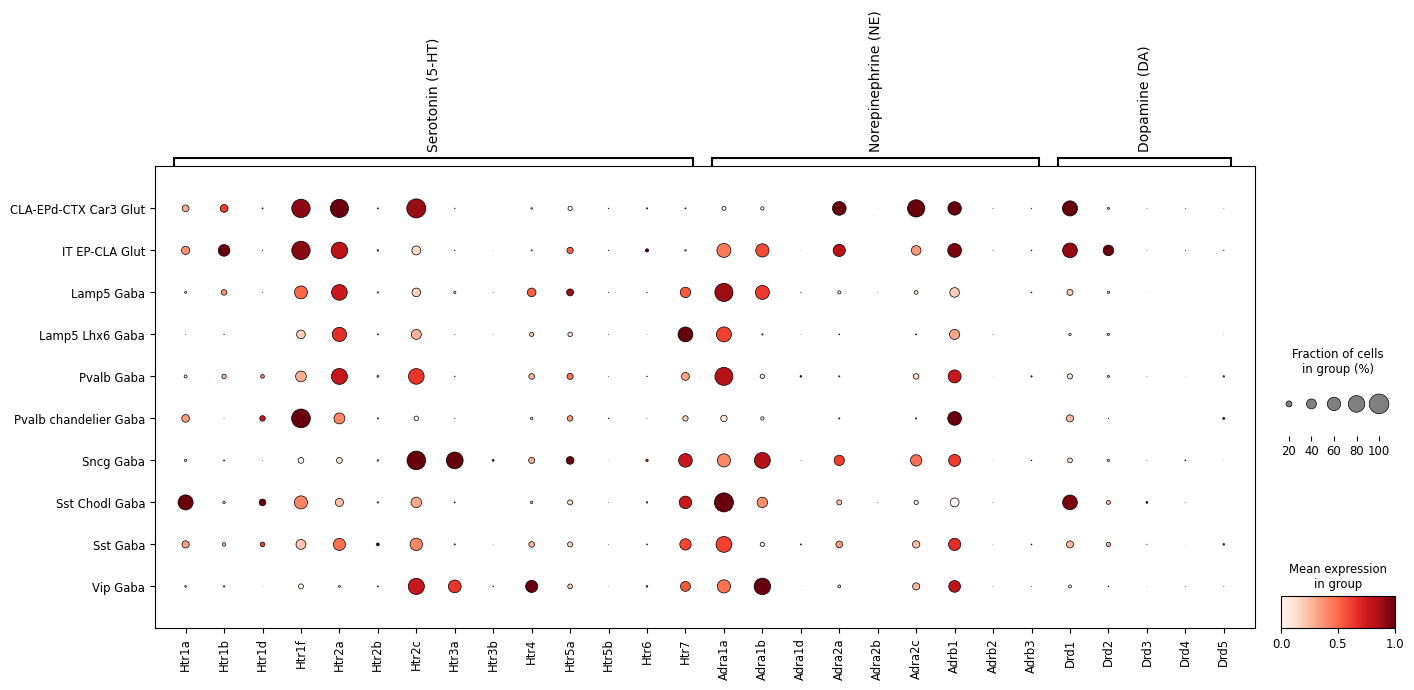

Saved: dotplot_CLA_receptors_by_subclass.png


In [12]:
receptor_groups = {}
sero_available = [g for g in serotonin_receptors if g in receptor_genes]
ne_available = [g for g in norepinephrine_receptors if g in receptor_genes]
da_available = [g for g in dopamine_receptors if g in receptor_genes]
if sero_available: receptor_groups['Serotonin (5-HT)'] = sero_available
if ne_available: receptor_groups['Norepinephrine (NE)'] = ne_available
if da_available: receptor_groups['Dopamine (DA)'] = da_available

dp = sc.pl.dotplot(
    adata_cla,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_CLA_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_CLA_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertypes with >= 50 cells: 37


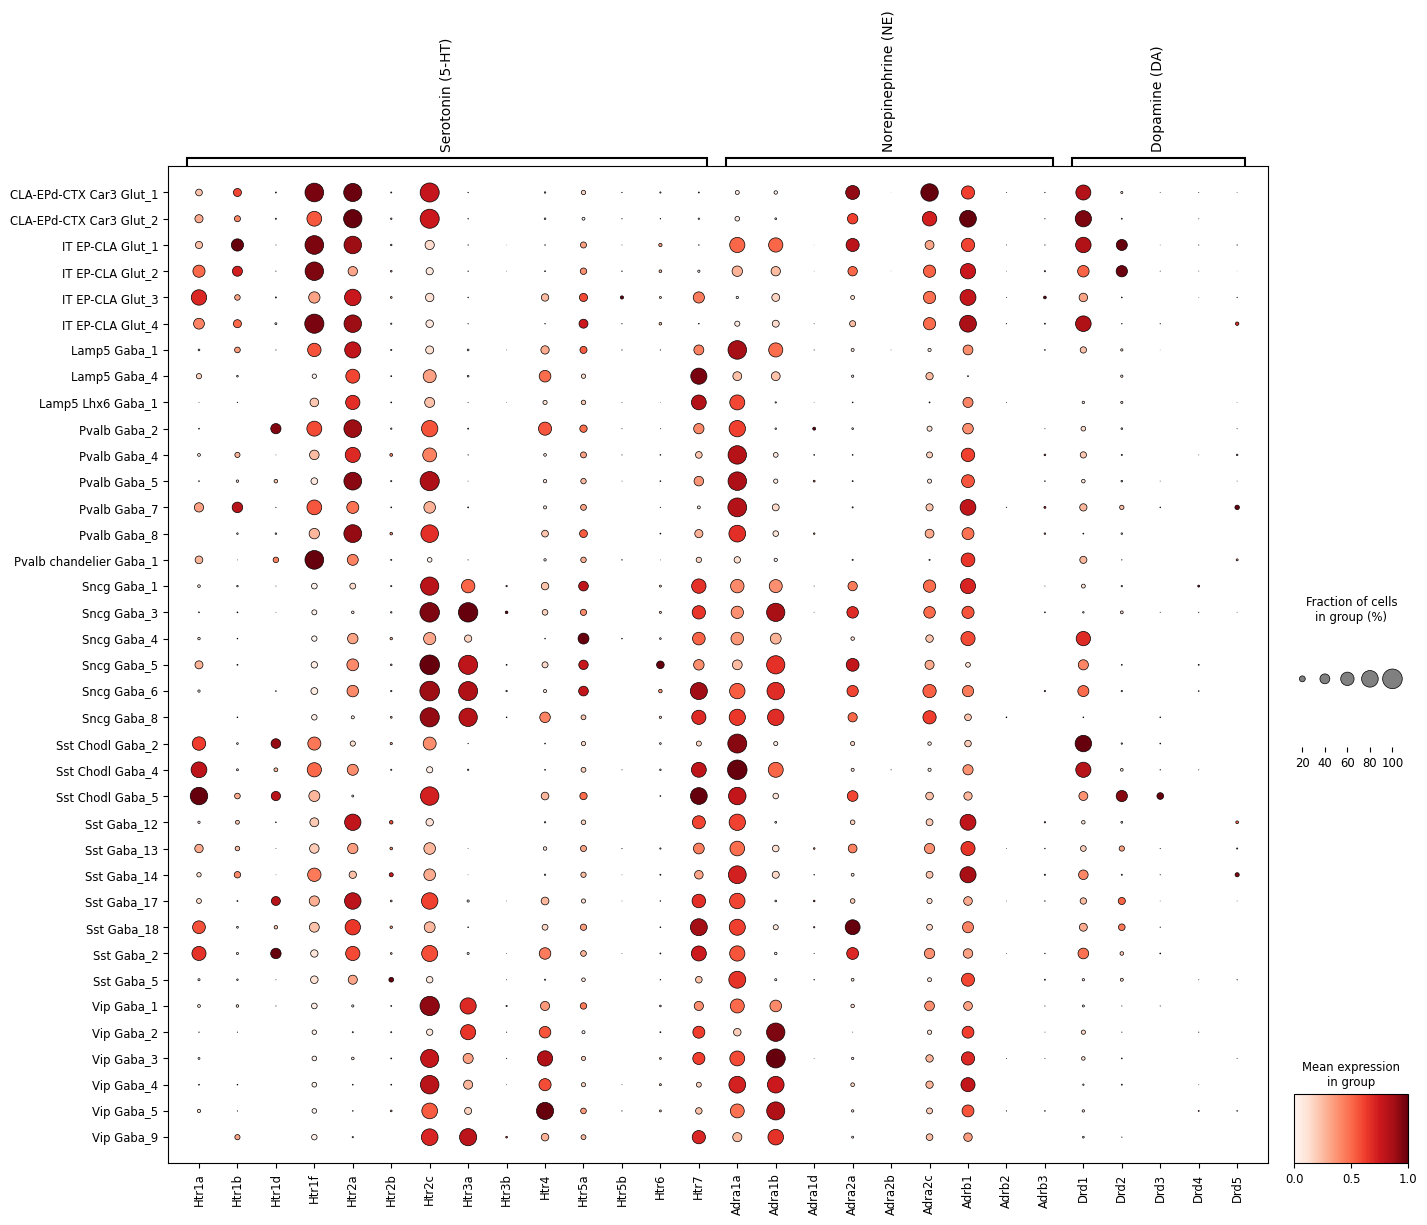

Saved: dotplot_CLA_receptors_by_supertype.png


In [13]:
min_cells = 50
supertype_counts = adata_cla.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_cla[adata_cla.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(8, n_st * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_CLA_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_CLA_receptors_by_supertype.png")

## 9. Including Glia: Neurons + Microglia + Astrocytes

CTXsp glia cells:
  319 Astro-TE NN: 19,140 cells
  334 Microglia NN: 6,164 cells


Reused BLA glia data: 25,304 cells
Saved metadata to cla_10x_metadata.csv



Combined: 53,972 cells, 12 subclasses


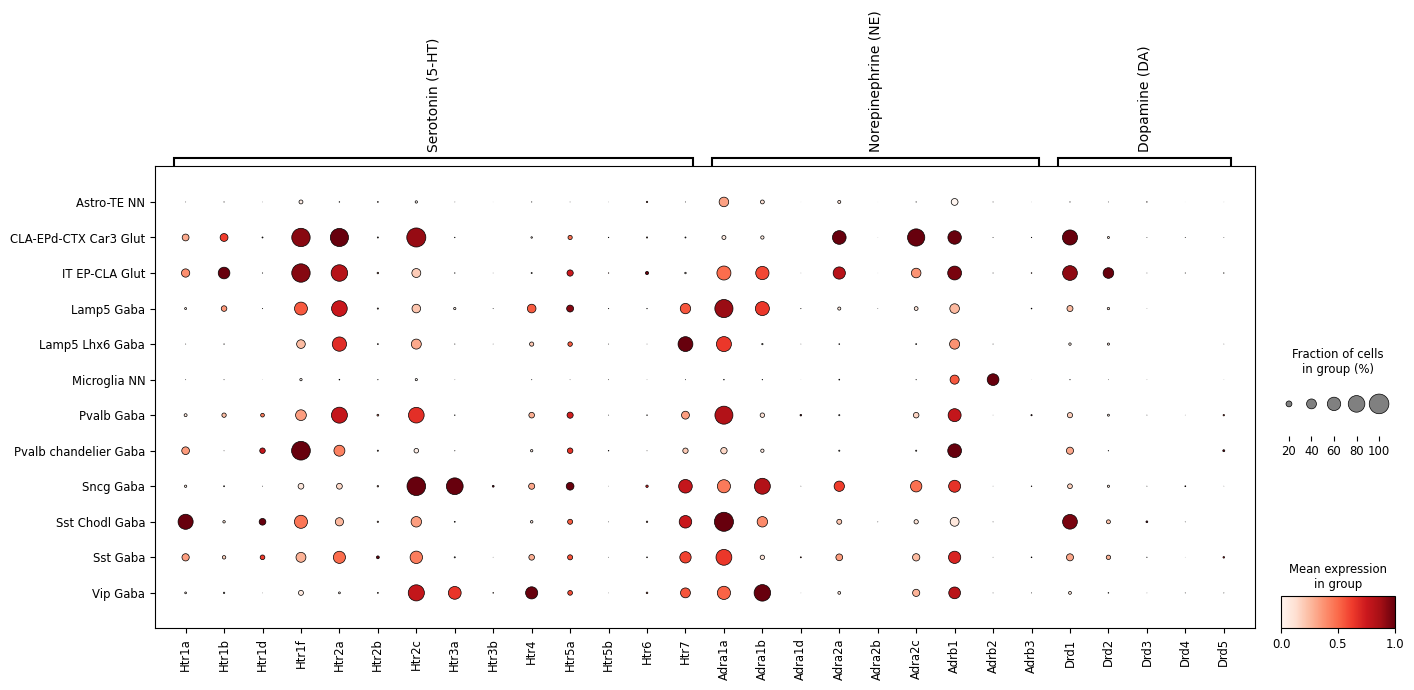

Saved: dotplot_CLA_receptors_with_glia.png


In [14]:
glia_subclasses = ['319 Astro-TE NN', '334 Microglia NN']
glia_cells = ctxsp_cells[ctxsp_cells['subclass'].isin(glia_subclasses)].copy()

print(f"CTXsp glia cells:")
for sc_name, count in glia_cells.groupby('subclass', observed=True).size().items():
    print(f"  {sc_name}: {count:,} cells")

glia_csv = 'cla_10x_glia_expression.csv'

if os.path.exists(glia_csv):
    glia_expression = pd.read_csv(glia_csv, index_col=0)[receptor_genes]
    print(f"Loaded from {glia_csv}: {glia_expression.shape[0]:,} cells")
elif os.path.exists('bla_10x_glia_expression.csv'):
    # Reuse BLA glia data (same CTXsp glia)
    glia_expression = pd.read_csv('bla_10x_glia_expression.csv', index_col=0)[receptor_genes]
    glia_expression.to_csv(glia_csv)
    print(f"Reused BLA glia data: {glia_expression.shape[0]:,} cells")
else:
    glia_matrices = glia_cells.groupby('feature_matrix_label').size()
    glia_expr_frames = []
    for matrix_label in glia_matrices.index:
        dataset_label = glia_cells[glia_cells['feature_matrix_label'] == matrix_label]['dataset_label'].iloc[0]
        file_name = f"{matrix_label}/log2"
        file_path = abc_cache.get_file_path(directory=dataset_label, file_name=file_name)
        adata = anndata.read_h5ad(file_path, backed='r')
        gene_mask = adata.var.index.isin(gene_ensembl_ids)
        gene_filtered = adata.var[gene_mask]
        glia_cell_labels = glia_cells[glia_cells['feature_matrix_label'] == matrix_label].index
        cell_mask = adata.obs.index.isin(glia_cell_labels)
        cell_idx = np.where(cell_mask)[0]
        gene_idx = np.where(gene_mask)[0]
        subset = adata[cell_idx, gene_idx].to_memory()
        expr_df = subset.to_df()
        expr_df.columns = gene_filtered['gene_symbol'].values
        glia_expr_frames.append(expr_df)
        adata.file.close()
        del adata
        print(f"  {matrix_label}: {cell_mask.sum():,} glia cells")
    glia_expression = pd.concat(glia_expr_frames)[receptor_genes]
    glia_expression.to_csv(glia_csv)
    print(f"Saved to {glia_csv}")

combined_expression = pd.concat([expression_data, glia_expression])
combined_cells = pd.concat([cla_cells, glia_cells])

meta_csv = 'cla_10x_metadata.csv'
combined_cells.loc[combined_expression.index,
    ['subclass', 'supertype', 'class', 'neurotransmitter']
].to_csv(meta_csv)
print(f"Saved metadata to {meta_csv}")

adata_combined = anndata.AnnData(
    X=combined_expression.values,
    obs=combined_cells.loc[combined_expression.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)
adata_combined.obs['subclass_short'] = adata_combined.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_combined.obs['subclass_short'] = pd.Categorical(adata_combined.obs['subclass_short'])

n_combined = adata_combined.obs['subclass_short'].cat.categories.size
print(f"\nCombined: {len(adata_combined):,} cells, {n_combined} subclasses")

dp3 = sc.pl.dotplot(
    adata_combined,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(6, n_combined * 0.5)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_CLA_receptors_with_glia.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_CLA_receptors_with_glia.png")

## 10. Summary Statistics

In [15]:
expr_df = pd.DataFrame(
    adata_cla.X,
    index=adata_cla.obs.index,
    columns=adata_cla.var.index
)
expr_df['subclass'] = adata_cla.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 80)
print("Mean Expression (log2) by CLA Subclass")
print("=" * 80)
display(mean_expr.round(2))

print("\n" + "=" * 80)
print("Fraction of Expressing Cells by CLA Subclass")
print("=" * 80)
display(frac_expr.round(3))

Mean Expression (log2) by CLA Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
CLA-EPd-CTX Car3 Glut,1.38,1.78,0.11,7.18,6.65,0.11,7.95,0.05,0.00,0.18,...,0.00,5.60,3.72,0.02,0.04,4.41,0.27,0.01,0.02,0.01
IT EP-CLA Glut,1.73,2.87,0.03,7.19,5.47,0.16,2.02,0.04,0.00,0.12,...,0.00,2.09,3.65,0.02,0.06,4.06,2.63,0.01,0.02,0.04
Lamp5 Gaba,0.26,1.03,0.02,4.37,5.07,0.13,2.20,0.33,0.02,2.07,...,0.01,0.64,2.19,0.00,0.07,1.13,0.33,0.00,0.00,0.00
Lamp5 Lhx6 Gaba,0.02,0.04,0.00,2.22,4.52,0.10,2.94,0.03,0.01,0.84,...,0.00,0.11,2.43,0.02,0.00,0.35,0.30,0.00,0.00,0.01
Pvalb Gaba,0.41,0.71,0.57,2.89,5.17,0.20,5.95,0.05,0.00,1.12,...,0.00,0.97,3.26,0.00,0.12,0.85,0.25,0.01,0.00,0.15
Pvalb chandelier Gaba,1.59,0.01,1.00,7.66,2.89,0.12,0.78,0.02,0.00,0.32,...,0.00,0.12,3.71,0.00,0.00,1.39,0.04,0.00,0.00,0.25
Sncg Gaba,0.29,0.10,0.01,1.02,1.07,0.15,8.74,6.44,0.20,1.20,...,0.00,2.71,3.02,0.01,0.05,0.81,0.30,0.01,0.08,0.00
Sst Chodl Gaba,4.50,0.32,1.29,3.76,1.78,0.14,3.20,0.09,0.00,0.39,...,0.01,0.66,1.83,0.01,0.00,4.25,0.62,0.22,0.01,0.00
Sst Gaba,1.54,0.53,0.81,2.44,3.31,0.40,4.05,0.13,0.01,1.11,...,0.00,1.43,3.11,0.01,0.07,1.41,0.75,0.03,0.00,0.18



Fraction of Expressing Cells by CLA Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
CLA-EPd-CTX Car3 Glut,0.244,0.296,0.020,0.916,0.900,0.022,0.961,0.009,0.000,0.033,...,0.000,0.840,0.604,0.003,0.007,0.704,0.048,0.003,0.004,0.002
IT EP-CLA Glut,0.317,0.499,0.006,0.917,0.794,0.035,0.350,0.008,0.001,0.022,...,0.000,0.384,0.626,0.003,0.012,0.682,0.440,0.002,0.004,0.008
Lamp5 Gaba,0.047,0.187,0.005,0.572,0.740,0.025,0.333,0.056,0.003,0.335,...,0.002,0.113,0.384,0.000,0.014,0.206,0.059,0.001,0.000,0.000
Lamp5 Lhx6 Gaba,0.003,0.007,0.000,0.335,0.655,0.019,0.407,0.004,0.001,0.128,...,0.000,0.019,0.412,0.003,0.000,0.062,0.053,0.000,0.000,0.001
Pvalb Gaba,0.080,0.134,0.109,0.448,0.759,0.042,0.741,0.010,0.000,0.189,...,0.000,0.185,0.576,0.001,0.025,0.171,0.048,0.002,0.001,0.031
Pvalb chandelier Gaba,0.287,0.002,0.184,0.938,0.459,0.024,0.144,0.005,0.000,0.060,...,0.000,0.024,0.622,0.000,0.000,0.258,0.007,0.000,0.000,0.048
Sncg Gaba,0.058,0.019,0.003,0.193,0.197,0.032,0.932,0.810,0.042,0.209,...,0.000,0.483,0.517,0.001,0.010,0.151,0.054,0.003,0.017,0.001
Sst Chodl Gaba,0.703,0.062,0.239,0.583,0.312,0.029,0.433,0.018,0.000,0.065,...,0.002,0.132,0.348,0.002,0.000,0.681,0.118,0.042,0.002,0.000
Sst Gaba,0.266,0.099,0.148,0.401,0.526,0.077,0.544,0.023,0.001,0.190,...,0.000,0.268,0.533,0.002,0.014,0.255,0.135,0.006,0.000,0.035
